# RNN text classification model for IMDB reviews

I love watching movies. It's a way to leave the world you live in and enter another, and for the length of a good movie you are completely captured by the emotions and themes within bringing new perspectives and thoughts. I also love discussing and reviewing movies, so after learning about the IMDB movie reviews dataset avaiable on tensorflow_datasets, I decided to join my hobby with my career skills and create this personal project on a model that can identify whether a review is positive or negative.

The format of the RNN model is built as a tf.keras.Sequential, with an encoder -> embedding -> RNNs -> final processing layers as the format (based off tutorials from tensorflow.org)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
def plot_graphs(history, metric):
    # Function for basic plotting
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [6]:
# Download the tfds IMDB dataset
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
# See example review
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [9]:
# Shuffle the data for training and create batches of (text, label) pairs
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'<br /><br />An old man works as a janitor in a mental hospital to be close to his wife who is a patient there and to try to get her out.<br /><br />This is surely one of the most forgotten masterpieces of the silent era and an oddity in the history of Japanese cinema. Long thought lost, a print was found in the 70s and a music soundtrack added to it, which fits perfectly with the images. It might have been influenced by cabinet of doctor Caligary (director Kinugasa claimed he never saw the German film). However it surpasses it in style and in its more convincing (and chilly) portray of the inner mental state of the inmates in the asylum. To achieve this, the film makes use of every single film technique available at the time: multiple exposures and out of focus subjective point of view, tilted camera angles, fast and slow motion, expressionist lighting and superimpositions among others. It is also a very complicated film to follow, as it has not got intertitles.<br /><br />T

In [10]:
# Using basic/default TextVectorization layer
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 13,  13,  34, ...,   0,   0,   0],
       [142,   1, 912, ...,   0,   0,   0],
       [ 34, 165,   1, ...,   0,   0,   0]])

In [14]:
# Building the model which consists of:
# tf.keras.Sequential -> encoder -> embedding layer -> RNN -> final processing

model1 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
model1.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics=['accuracy'])

In [17]:
# Train the model
history1 = model1.fit(train_dataset, epochs=10,
                     validation_data=test_dataset,
                     validation_steps=30)

Epoch 1/10
391/391 [==============================] - 510s 1s/step - loss: 0.6445 - accuracy: 0.5759 - val_loss: 0.5148 - val_accuracy: 0.7177
Epoch 2/10
391/391 [==============================] - 596s 2s/step - loss: 0.4286 - accuracy: 0.8152 - val_loss: 0.3862 - val_accuracy: 0.8203
Epoch 3/10
391/391 [==============================] - 466s 1s/step - loss: 0.3586 - accuracy: 0.8460 - val_loss: 0.3711 - val_accuracy: 0.8573
Epoch 4/10
391/391 [==============================] - 362s 925ms/step - loss: 0.3346 - accuracy: 0.8590 - val_loss: 0.3513 - val_accuracy: 0.8625
Epoch 5/10
391/391 [==============================] - 417s 1s/step - loss: 0.3189 - accuracy: 0.8654 - val_loss: 0.3253 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 503s 1s/step - loss: 0.3121 - accuracy: 0.8675 - val_loss: 0.3217 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 356s 910ms/step - loss: 0.3088 - accuracy: 0.8687 - val_loss: 0.3181 - val_accuracy: 

In [18]:
test_loss, test_acc = model1.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 96s 246ms/step - loss: 0.3263 - accuracy: 0.8472
Test Loss: 0.3262767195701599
Test Accuracy: 0.8471999764442444


(0.0, 0.6617846354842186)

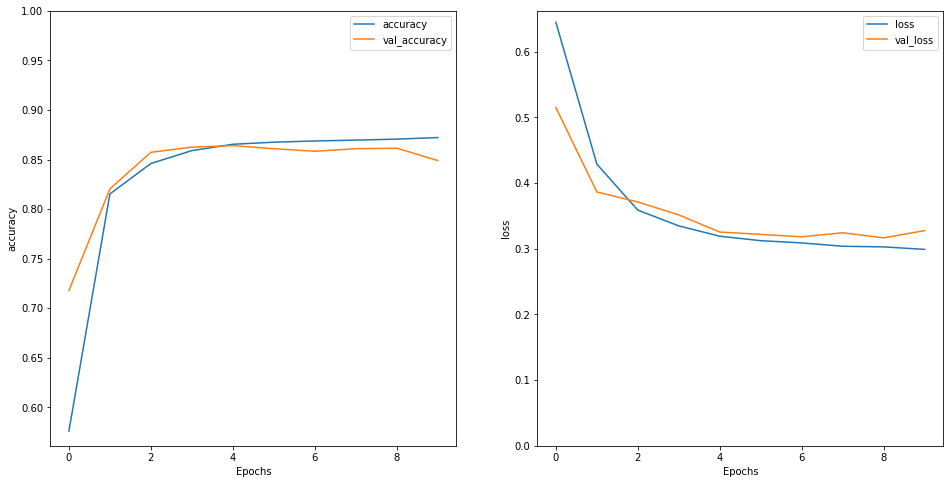

In [19]:
# Plottng model accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')
plt.ylim(0, None)

In [27]:
# Now trying a prediction on a positive brand new sentence. 
# If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('The movie was very good. The animation and the graphics '
               'were very impressive and unbelievable. I would recommend this movie.')
prediction = model1.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 0s 21ms/step


array([[0.8520975]], dtype=float32)

In [26]:
# Now trying a prediction on a negative brand new sentence. 
# If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('The movie was extremely bad and horrible. The acting was cringe '
               'and the script was not good. I would not recommend this movie.')
prediction = model1.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 0s 23ms/step


array([[-2.4300206]], dtype=float32)

In [28]:
# Now trying a prediction on a trickier sentence that contains both positive and negative feedback.
# If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('While the movie was very good in its plot, the acting and '
               'directing was subpar. I would only recommend this movie to people for the plot.')
prediction = model1.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 0s 22ms/step


array([[-0.24543403]], dtype=float32)

## Multiple RNN layers

From reading a tutorial on tensorflow.org, I learned that RNN models can also have multiple RNN layers, controlled by the return_sequences arguement. The below trains a new model that has multiple RNN layers, which should lead to higher accuracy in the intensity of positive/negative reviews.

In [29]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [30]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics=['accuracy'])

In [31]:
history2 = model2.fit(train_dataset, epochs=10,
                     validation_data=test_dataset,
                     validation_steps=30)

Epoch 1/10
391/391 [==============================] - 686s 2s/step - loss: 0.6357 - accuracy: 0.5776 - val_loss: 0.4523 - val_accuracy: 0.8005
Epoch 2/10
391/391 [==============================] - 647s 2s/step - loss: 0.3899 - accuracy: 0.8272 - val_loss: 0.3553 - val_accuracy: 0.8396
Epoch 3/10
391/391 [==============================] - 648s 2s/step - loss: 0.3398 - accuracy: 0.8527 - val_loss: 0.3694 - val_accuracy: 0.8562
Epoch 4/10
391/391 [==============================] - 636s 2s/step - loss: 0.3247 - accuracy: 0.8613 - val_loss: 0.3341 - val_accuracy: 0.8396
Epoch 5/10
391/391 [==============================] - 642s 2s/step - loss: 0.3115 - accuracy: 0.8648 - val_loss: 0.3301 - val_accuracy: 0.8396
Epoch 6/10
391/391 [==============================] - 752s 2s/step - loss: 0.3106 - accuracy: 0.8638 - val_loss: 0.3481 - val_accuracy: 0.8359
Epoch 7/10
391/391 [==============================] - 890s 2s/step - loss: 0.3002 - accuracy: 0.8693 - val_loss: 0.3204 - val_accuracy: 0.8526

In [32]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 194s 497ms/step - loss: 0.3228 - accuracy: 0.8420
Test Loss: 0.32277968525886536
Test Accuracy: 0.8420400023460388


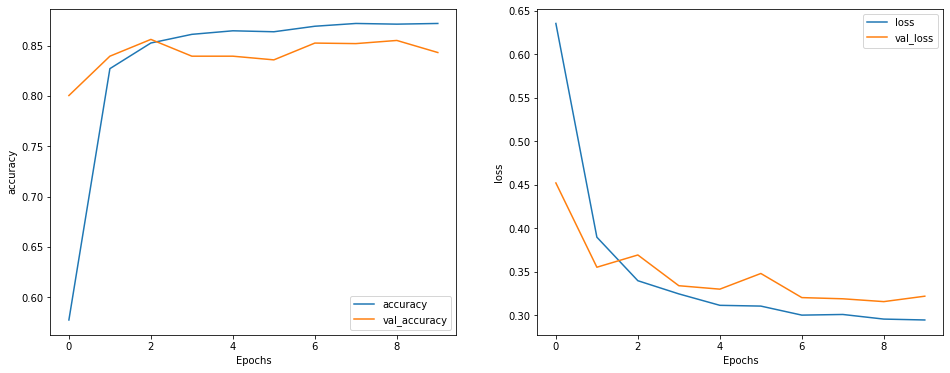

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')

In [35]:
# Now trying a prediction on a positive brand new sentence. 
# If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('The movie was very good. The animation and the graphics '
               'were very impressive and unbelievable. I would recommend this movie.')
prediction = model2.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 5s 5s/step


array([[0.68116033]], dtype=float32)

In [36]:
# Now trying a prediction on a negative brand new sentence. 
# If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('The movie was extremely bad and horrible. The acting was cringe '
               'and the script was not good. I would not recommend this movie.')
prediction = model2.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 0s 24ms/step


array([[-3.2273037]], dtype=float32)

In [37]:
# Now trying a prediction on a trickier sentence that contains both positive and negative feedback.
# If the prediction is >= 0.0, it is positive else it is negative.
sample_text = ('While the movie was very good in its plot, the acting and '
               'directing was subpar. I would only recommend this movie to people for the plot.')
prediction = model2.predict(np.array([sample_text]))
prediction

1/1 [==============================] - 0s 23ms/step


array([[-0.7708351]], dtype=float32)

## Conclusion

Not much data exploration/pre-processing/feature engineering was done on the dataset as it was provided by tensorflow_datasets, and assumed to be ready for training.

Both the simple RNN model and the multi-layered RNN model performed accurately for the simple test cases provided. Comparing between the two, the intensity of the positive/negative prediction changed between the two models.

For example, for the sample text 

"While the movie was very good in its plot, the acting and directing was subpar. I would only recommend this movie to people for the plot."

the first model predicted -0.25 (ie slightly negative review, quite neutral), while the multi-layered model predicted -0.78 (ie more negative of a review). This makes sense to me, and is a simple occurrence that gives me confidence that the second model is more accurate and able to pick-up more nuances in the reviews.

If I were to guess what the above review is trying to portray, I would agree with the 2nd model more as the reviewer is only reccommending the movie to a very small audience, so it is generally more negative than neutral.